In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import matplotlib.pyplot as plt

In [102]:
df = pd.read_csv('data/train_data.csv')

In [103]:
key_columns = ['Gender', 'IsActiveMember', 'Exited', 'Geography', 'NumOfProducts', 'Age']
utils_columns = ['Balance', 'Tenure', 'EstimatedSalary', 'CreditScore', 'HasCrCard']

In [104]:
df = df[key_columns + utils_columns]
df.head()

,Gender,IsActiveMember,Exited,Geography,NumOfProducts,Age,Balance,Tenure,EstimatedSalary,CreditScore,HasCrCard
0,Male,1.0,0,France,1,28.0,131694.04,7,161205.61,627,1.0
1,Male,1.0,0,France,2,34.0,0.00,2,181419.29,597,0.0
2,Male,1.0,0,France,2,39.0,0.00,7,100862.54,724,1.0
3,Female,0.0,1,Germany,3,56.0,118577.24,5,61164.45,663,1.0
4,Female,1.0,0,France,2,33.0,0.00,5,103737.82,627,1.0


# Pre-processing

### TrainTest - Nettoyage - Encodage

In [105]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [106]:
trainset['Exited'].value_counts()

Exited
0    90534
1    24329
Name: count, dtype: int64

In [107]:
testset['Exited'].value_counts()

Exited
0    22595
1     6121
Name: count, dtype: int64

### Outliers

In [108]:
def remove_outliers(df):
    list_col_name = ['Age']
    for col in list_col_name:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers_df = df.query(f"{col} < @lower_bound | {col} > @upper_bound")
        df = df.drop(outliers_df.index)

    return df


### Encodage

In [109]:
def feature_engineering(df):
    df['IsGerman'] = (df['Geography'] == 'Germany').astype(int)

    df["NumProductsGroup"] = np.where(df["NumOfProducts"] == 1, 1,
                         np.where(df["NumOfProducts"] == 2, 2, 3))
    
    # df['HasBalance'] = (df['Balance'] > 0).astype(int)

    # df["AgeGroup"] = pd.cut(
    #     df["Age"],
    #     bins=[0, 30, 35, 40, 45, 50, 55, 60, 100],
    #     labels=[1, 2, 3, 4, 5, 6, 7, 8]
    # ).astype(int)

    # df["AgeOver39"] = (df["Age"] > 39).astype(int)


    bins = [-1, 0, 50000, 100000, 150000, 200000, df["Balance"].max()]
    labels = ["Nulle", "Faible", "Moyen", "Normal", "Élevé", "Très élevé"]
    df["BalanceCat"] = pd.cut(df["Balance"], bins=bins, labels=labels)

    # df['ratioDepense'] = df.query("Balance > 0")["Balance"] / ((df['Tenure'] * df['EstimatedSalary']) + 1e-5)
    # df['ratioDepense'] = df['ratioDepense'].fillna(0)
    # seuil = df["ratioDepense"].median()
    # df["isSpender"] = (df["ratioDepense"] > seuil).astype(int)

    df["is_young_high_income"] = (df["Age"] < 30) & (df["EstimatedSalary"] > 100000)

    df["ratio_salary_Age"] = (df["EstimatedSalary"] +1e-5) / df["Age"]

    df["is_active_creditCard"] = (df["HasCrCard"] == 1) & (df["IsActiveMember"] == 1)

    

    return df

In [110]:
def imputation(df):
    # df = df.drop(columns=["Age", "Balance", "Tenure", "NumOfProducts", "Geography", "HasCrCard", "EstimatedSalary", "CreditScore"])
    df = df.drop(columns=["NumOfProducts", "Geography"])
    return df

In [111]:
def preprocessing(df):
    # df = remove_outliers(df)
    df = feature_engineering(df)
    # df = encodage(df)
    df = imputation(df)
    
    
    X = df.drop('Exited', axis=1)
    y = df['Exited']
    print(y.value_counts())

    return X, y

In [112]:
X_train, y_train = preprocessing(trainset)
X_test, y_test= preprocessing(testset)

Exited
0    90534
1    24329
Name: count, dtype: int64
Exited
0    22595
1     6121
Name: count, dtype: int64


## Modellisation

In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

In [114]:
# l’ordre que tu as défini pour ta variable catégorisée
BALANCE_ORDER = ["Nulle", "Faible", "Moyen", "Normal", "Élevé", "Très élevé"]

In [115]:
column_transformer = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"), ["Gender"]),
        ("encoderO", OrdinalEncoder(categories=[BALANCE_ORDER], handle_unknown="use_encoded_value", unknown_value=-1),["BalanceCat"]),
        # ("poly", PolynomialFeatures(degree=2, include_bias=False), ["Tenure", "HasCrCard", "EstimatedSalary", "CreditScore"])
    ],
    remainder="passthrough",                 # garde les autres colonnes telles quelles
    verbose_feature_names_out=False,
    )

In [116]:
preprocessor = make_pipeline(
    column_transformer,
    # PolynomialFeatures(interaction_only=True, include_bias=False),
    SelectKBest(f_classif),
)

In [117]:
RandomForest = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("rf", RandomForestClassifier(random_state=0, n_jobs=4))
    ])

DecisionTreeC = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("decisionTreeClassifier", DecisionTreeClassifier(random_state=0))
    ])
# AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
# KNNe = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier(n_jobs=2))
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("xgb", XGBClassifier(random_state=0, n_jobs=4))
    ])

In [118]:
dict_of_models = {'RandomForest' : RandomForest, 
                  'decisionTreeClassifier' : DecisionTreeC,
                  'xgb' : xgb_pipe,
                #   'AdaBoost' : AdaBoost,
                #   'KNN' : KNNe
                  }

## Evaluation

In [119]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [120]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1 ,1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    

In [121]:
def get_feature_importances(pipeline, step_preprocessor, step_model_name):
    step_model_name = pipeline.named_steps[step_model_name]
    feature_names = pipeline.named_steps[step_preprocessor].get_feature_names_out()
    # Récupérer les importances
    importances = step_model_name.feature_importances_
    # Mettre dans un DataFrame et tracer
    pd.DataFrame(importances, index=feature_names, columns=["importance"]).sort_values(by="importance", ascending=False).plot.bar(figsize=(12,5))

RandomForest
[[20693  1902]
 [ 2818  3303]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     22595
           1       0.63      0.54      0.58      6121

    accuracy                           0.84     28716
   macro avg       0.76      0.73      0.74     28716
weighted avg       0.83      0.84      0.83     28716

decisionTreeClassifier
[[19701  2894]
 [ 2834  3287]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     22595
           1       0.53      0.54      0.53      6121

    accuracy                           0.80     28716
   macro avg       0.70      0.70      0.70     28716
weighted avg       0.80      0.80      0.80     28716

xgb
[[21383  1212]
 [ 2751  3370]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22595
           1       0.74      0.55      0.63      6121

    accuracy                           0.86     2

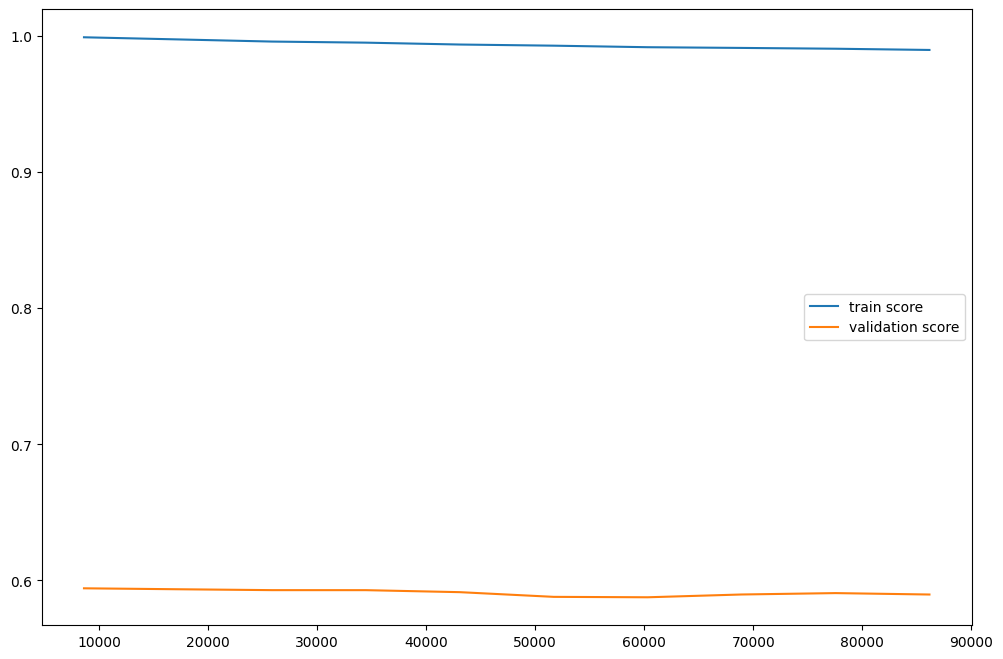

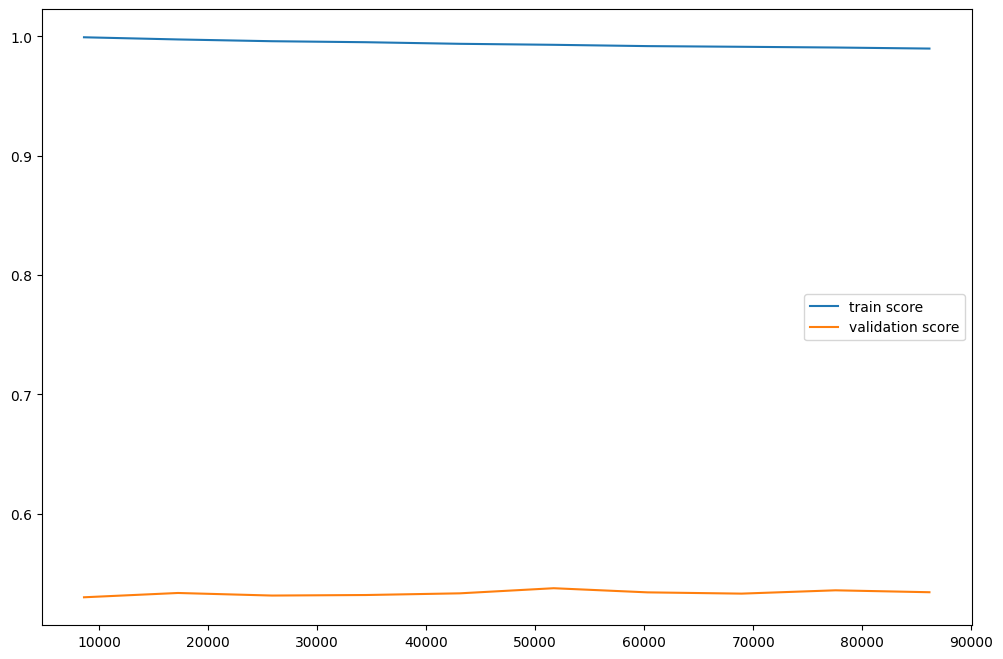

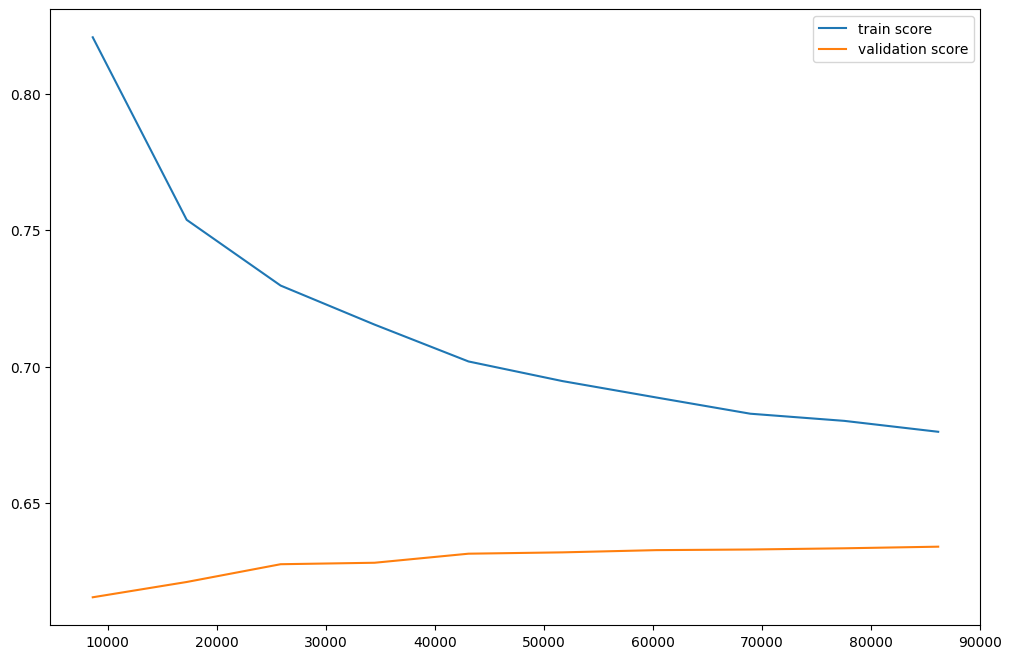

In [122]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)


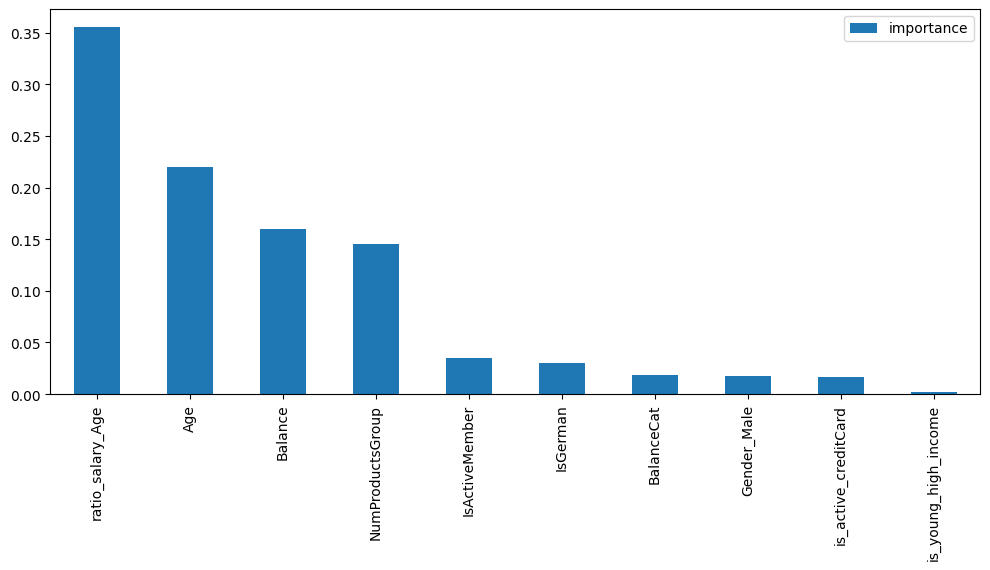

In [123]:
get_feature_importances(RandomForest, "preprocessor", "rf")

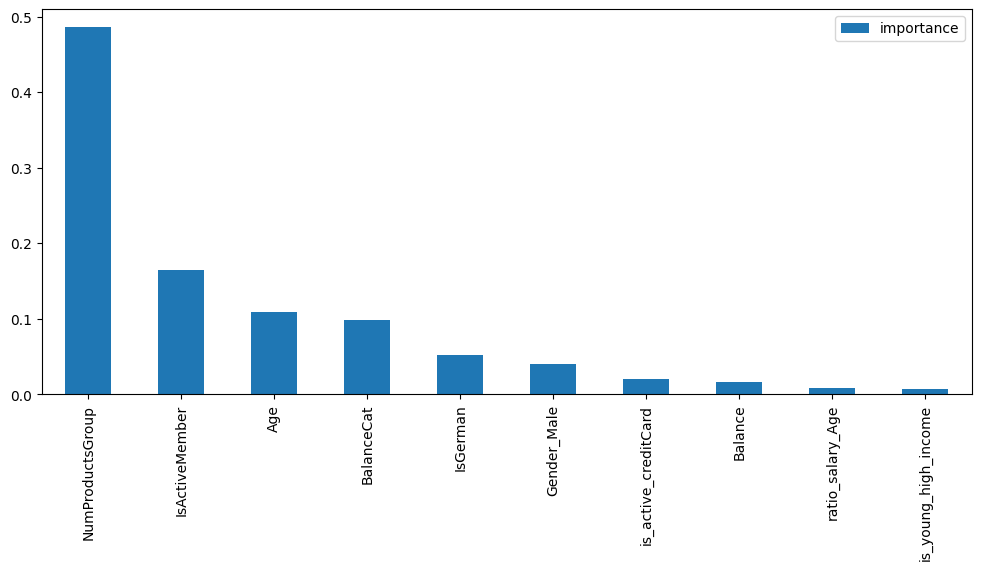

In [124]:
get_feature_importances(xgb_pipe, "preprocessor", "xgb")

## OPTIMISATION


In [125]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [126]:
hyper_params = {'rf__n_estimators' : [500, 1000],
                "rf__max_depth": [None, 8, 12, 16, 20],
                "rf__min_samples_split": [2, 5, 10],
                "rf__min_samples_leaf": [1, 5, 10, 20, 30],
                "rf__max_features": ["sqrt", 0.5, None],
                "rf__class_weight": ["balanced", "balanced_subsample"],
                'preprocessor__selectkbest__k':range(4, 10),
                }

In [127]:
hyper_params_XGB = {
    # Complexité du modèle
    "xgb__subsample": [0.7, 0.8, 0.9, 1.0],
    "xgb__reg_lambda": [8, 9, 10],
    "xgb__reg_alpha": [0.4, 0.5, 0.6, 0.7, 0.8],
    "xgb__n_estimators": [1040, 1050, 1060, 1070, 1080],  # gros nombre + early stopping
    "xgb__min_child_weight": [2, 3, 4],
    "xgb__max_depth": [4, 5, 6],
    "xgb__max_delta_step" :[2],
    "xgb__learning_rate": [0.008, 0.009, 0.01, 0.011, 0.012, 0.015],
    "xgb__gamma": [0.9, 1, 1.1, 1.2],
    "xgb__colsample_bytree": [0.8, 0.9, 1.0],
    'preprocessor__selectkbest__k':range(4, 18),
}


In [128]:
grid = RandomizedSearchCV(xgb_pipe, hyper_params_XGB, scoring='f1', cv=4 ,n_jobs=4, n_iter=500) #n_iter=120
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

/home/simon/projects/bankchurn_v2/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:782: UserWarning: k=17 is greater than n_features=14. All the features will be returned.
  warnings.warn(
/home/simon/projects/bankchurn_v2/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:782: UserWarning: k=17 is greater than n_features=14. All the features will be returned.
  warnings.warn(
/home/simon/projects/bankchurn_v2/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:782: UserWarning: k=17 is greater than n_features=14. All the features will be returned.
  warnings.warn(
/home/simon/projects/bankchurn_v2/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:782: UserWarning: k=17 is greater than n_features=14. All the features will be returned.
  warnings.warn(
/home/simon/projects/bankchurn_v2/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_

{'xgb__subsample': 1.0, 'xgb__reg_lambda': 9, 'xgb__reg_alpha': 0.4, 'xgb__n_estimators': 1050, 'xgb__min_child_weight': 3, 'xgb__max_depth': 5, 'xgb__max_delta_step': 2, 'xgb__learning_rate': 0.015, 'xgb__gamma': 1.1, 'xgb__colsample_bytree': 1.0, 'preprocessor__selectkbest__k': 14}
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22595
           1       0.73      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716



[[21366  1229]
 [ 2727  3394]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22595
           1       0.73      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716



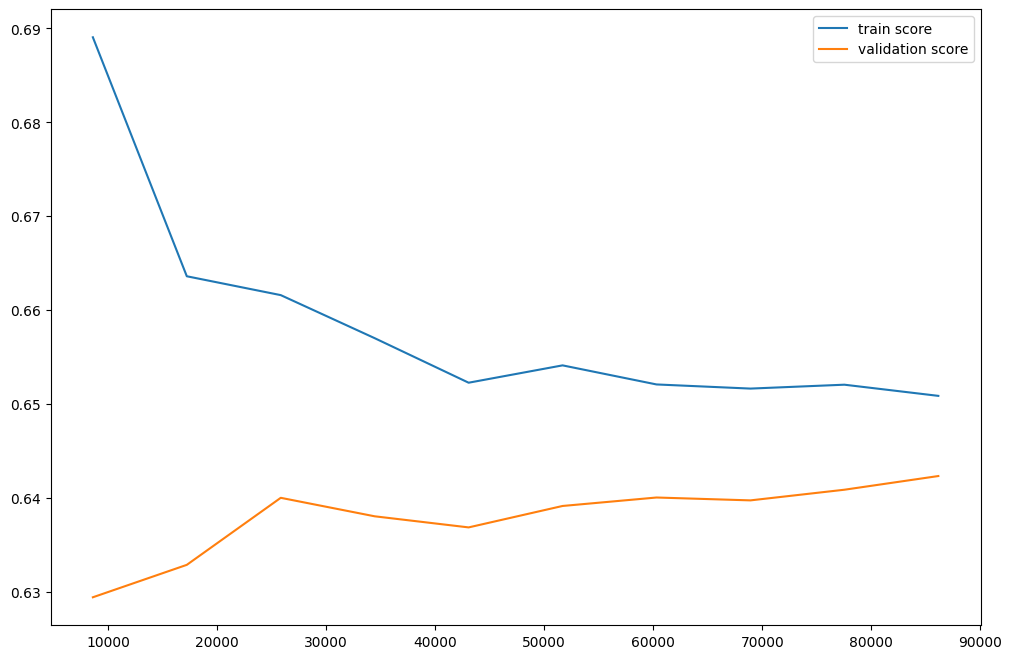

In [129]:
evaluation(grid.best_estimator_)

### Precision Recall Curve

In [130]:
from sklearn.metrics import precision_recall_curve

In [131]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1])

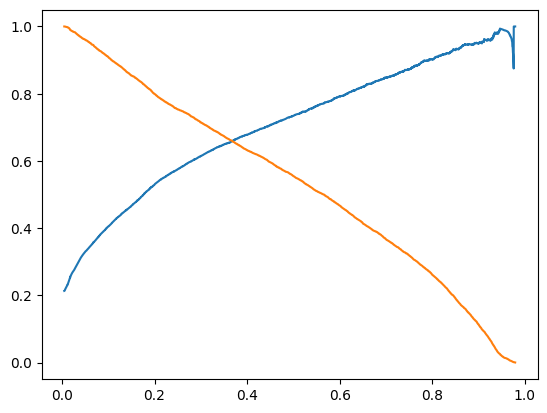

In [132]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend
plt.show()

In [133]:
def best_f1(model):
    best_t, best_f1 = 0, 0
    proba = model.predict_proba(X_test)[:, 1]
    for t in np.linspace(0.2, 0.8, 60):
        preds = (proba > t).astype(int)
        score = f1_score(y_test, preds)
        if score > best_f1:
            best_f1, best_t = score, t

    best_threshold = best_t
    print("Best threshold:", best_t, "F1:", best_f1)
    return best_threshold

In [134]:
best_threshold = best_f1(grid.best_estimator_)


Best threshold: 0.3322033898305085 F1: 0.6620537820412015


In [135]:
def model_final(model, X, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]  # proba classe positive
    return (proba > threshold).astype(int)

In [136]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=best_threshold)

## Entrainement du model sur tout le dataset

In [137]:
df = pd.read_csv('data/train_data.csv')

In [138]:
df = df[key_columns + utils_columns]

In [139]:
X_df, y_df = preprocessing(df)

Exited
0    113129
1     30450
Name: count, dtype: int64


In [140]:
final_model = grid.best_estimator_
final_model.fit(X_df, y_df)   # <--- refit ici

y_pred_df = model_final(final_model, X_df, threshold=best_threshold)


In [141]:
f1_score(y_df, y_pred_df)

0.6728358020402362

## Prediction kaggle

In [142]:
df_kaggle = pd.read_csv('data/test_data.csv')

In [143]:
# 1) garde l'ID AVANT le preprocessing
id_col = "ID"          # ou "CustomerId" selon ton fichier Kaggle
test_ids = df_kaggle[id_col].copy()

In [144]:
# key_columns_kaglle = ['Gender', 'IsActiveMember', 'Geography', 'NumOfProducts', 'Age']
# utils_columns_kaggle = ['Balance', 'Tenure', 'EstimatedSalary', 'CreditScore', 'HasCrCard']

In [145]:
# df_kaggle = df_kaggle[key_columns_kaglle + utils_columns_kaggle]

In [146]:
def preprocessing_kaggle(df):
    df = feature_engineering(df)
    # df = imputation(df)
    
    X = df

    return X

In [147]:
X_kaggle = preprocessing_kaggle(df_kaggle)

In [148]:
y_pred_kaggle = model_final(final_model, X_kaggle, threshold=best_threshold)

In [149]:
results = pd.DataFrame(
    {
        id_col: test_ids,
        "Exited": y_pred_kaggle
    }
)
#results.set_index("ID")

In [150]:
results.to_csv("predictions.csv", index=False)